# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-mitochondrial-proteins" data-toc-modified-id="Effects-of-HIF-1-on-mitochondrial-proteins-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Effects of HIF-1 on mitochondrial proteins</a></div><div class="lev1 toc-item"><a href="#HIF-1-effects-on-the-ribosome" data-toc-modified-id="HIF-1-effects-on-the-ribosome-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>HIF-1 effects on the ribosome</a></div><div class="lev1 toc-item"><a href="#Bioenergetics-of-HIF-1" data-toc-modified-id="Bioenergetics-of-HIF-1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bioenergetics of HIF-1</a></div><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-the-Proteasome-and-Mediator" data-toc-modified-id="Effects-of-HIF-1-on-the-Proteasome-and-Mediator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Effects of HIF-1 on the Proteasome and Mediator</a></div><div class="lev2 toc-item"><a href="#Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'" data-toc-modified-id="Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Effect of HIF-1 on proteins involved in 'protein catabolic process'</a></div><div class="lev1 toc-item"><a href="#Predicting-the-Egl-phenotype" data-toc-modified-id="Predicting-the-Egl-phenotype-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predicting the Egl phenotype</a></div>

In [16]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

In [31]:
q = 0.1

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sorter = {
          'a' : 4,
          'b' : 1,
          'c' : 3,
          'd' : 2,
          'e' : 0,
          'f' : 5,
          'g' : 6,
         }

In [32]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [33]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [34]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')
central_dogma = pd.read_excel('../input/central_dogma.xlsx')

In [35]:
melted_tissue = pd.melt(tissue_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_tissue = melted_tissue[melted_tissue.expressed == 1]

melted_phenotype = pd.melt(phenotype_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_phenotype = melted_phenotype[melted_phenotype.expressed == 1]

melted_go = pd.melt(go_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_go = melted_go[melted_go.expressed == 1]

In [37]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genotype_mapping[key]
    df['sort_order'] = sorter[key]
    df['abs_b'] = df.b.abs()
    frames += [df]

In [40]:
tidy_data = pd.concat(frames)
tidy_data.sort_values('sort_order', inplace=True)

In [57]:
def plot_by_term(term, melted_df, tidy=tidy_data, q=0.1, swarm=True):
    """Given a term, find all genes in the tidy dataframe that are annotated with the term and plot a boxplot."""
    genes = melted_df[melted_df.term.str.contains(term)].wbid
    ind = (tidy.qval < q) & (tidy.ens_gene.isin(genes) & (tidy.code != 'g'))
    if swarm:
        sns.swarmplot(x='genotype', y='b', data=tidy[ind])
    else:
        sns.violinplot(x='genotype', y='b', data=tidy[ind])
    return genes

# Effects of HIF-1 on mitochondrial proteins

AttributeError: module 'matplotlib.pyplot' has no attribute 'xtick'

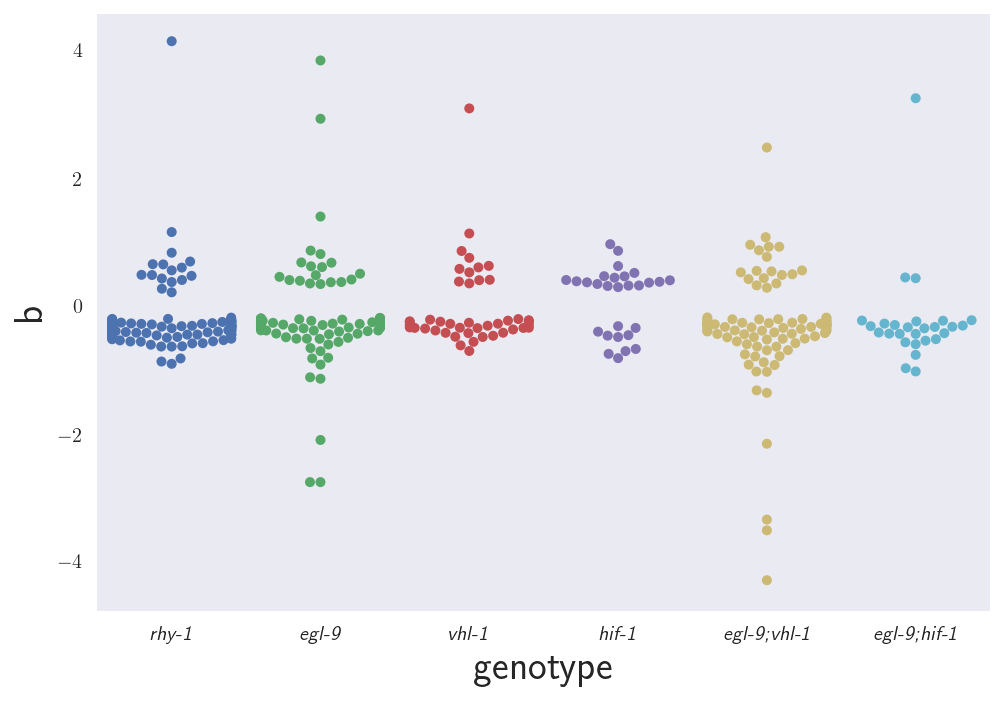

In [62]:
mito = plot_by_term('mitochondrion', melted_go)
plt.xtick(plt.gca().get_xticklabels(), fontsize=15)

In [43]:
tidy_data[
          (tidy_data.ens_gene.isin(mito)) &
          (tidy_data.qval < q) & 
          (tidy_data.b > 1) &
          (tidy_data.code != 'g') & 
          (tidy_data.code != 'c') & 
          (tidy_data.code != 'f')
         ].sort_values(['genotype', 'ext_gene'])[['qval', 'b', 'ext_gene',
                                                  'ens_gene', 'genotype']]

,qval,b,ext_gene,ens_gene,genotype
26043,5.023529e-02,2.474305,hsp-60,WBGene00002025,\emph{egl-9;vhl-1}
17976,3.332548e-11,1.064485,mai-1,WBGene00003124,\emph{egl-9;vhl-1}
31361,3.392838e-02,3.843943,ears-1,WBGene00001337,\emph{egl-9}
26043,1.551555e-02,2.927037,hsp-60,WBGene00002025,\emph{egl-9}
3010,3.753277e-02,1.389167,nnt-1,WBGene00003778,\emph{egl-9}
22382,6.426251e-02,1.145157,T15B12.1,WBGene00020530,\emph{rhy-1}
23794,7.538470e-02,4.146563,ant-1.1,WBGene00006439,\emph{rhy-1}
26043,2.289494e-02,3.089836,hsp-60,WBGene00002025,\emph{vhl-1}
22660,1.687223e-02,1.122326,skn-1,WBGene00004804,\emph{vhl-1}


# HIF-1 effects on the ribosome

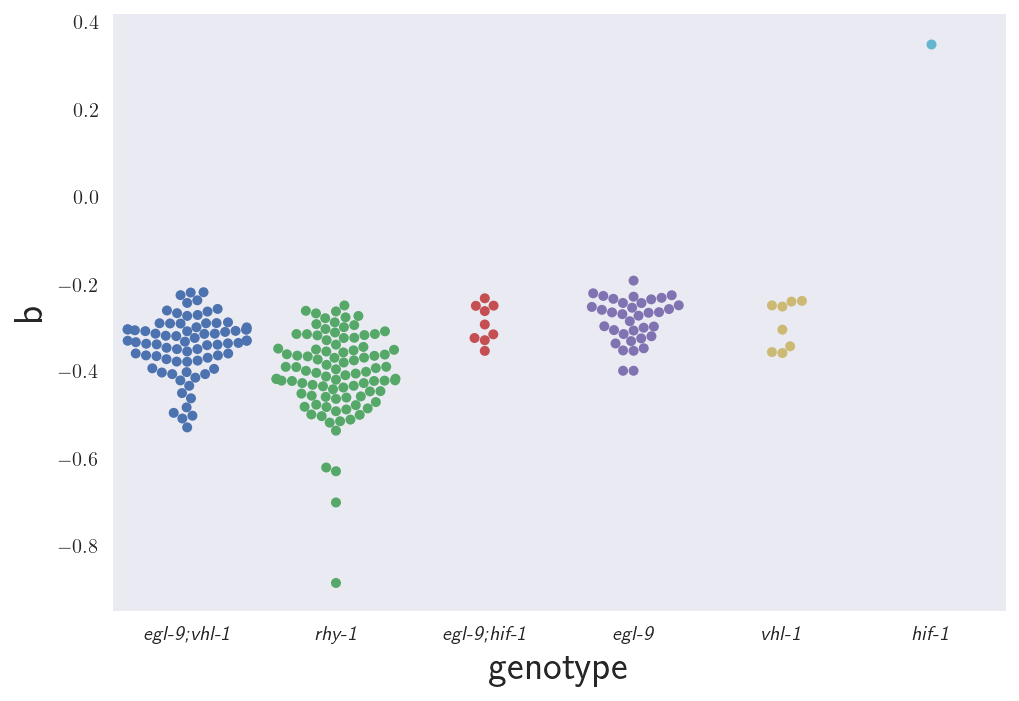

In [29]:
ribosome = plot_by_term('structural constituent of ribosome GO:0003735', melted_go)

# Bioenergetics of HIF-1

In [401]:
resp = tidy_data[tidy_data.ens_gene.isin(respiratory_complexes.ens_gene) 
                 & (tidy_data.qval < q)
                 & (tidy_data.genotype != 'g') 
                 & (tidy_data.genotype != 'f') 
                 & ((tidy_data.genotype != 'c'))].copy()
resp['complex'] = resp.ens_gene.map(lambda x: 
                                    respiratory_complexes[respiratory_complexes.ens_gene == x].complex.values[0])
resp['sort_order'] = resp.ens_gene.map(lambda x: 
                                       respiratory_complexes[respiratory_complexes.ens_gene == x].sort_order.values[0])
resp.sort_values('sort_order', inplace=True)
resp = resp[resp.complex != 'Ubiquinone Biosynthesis']

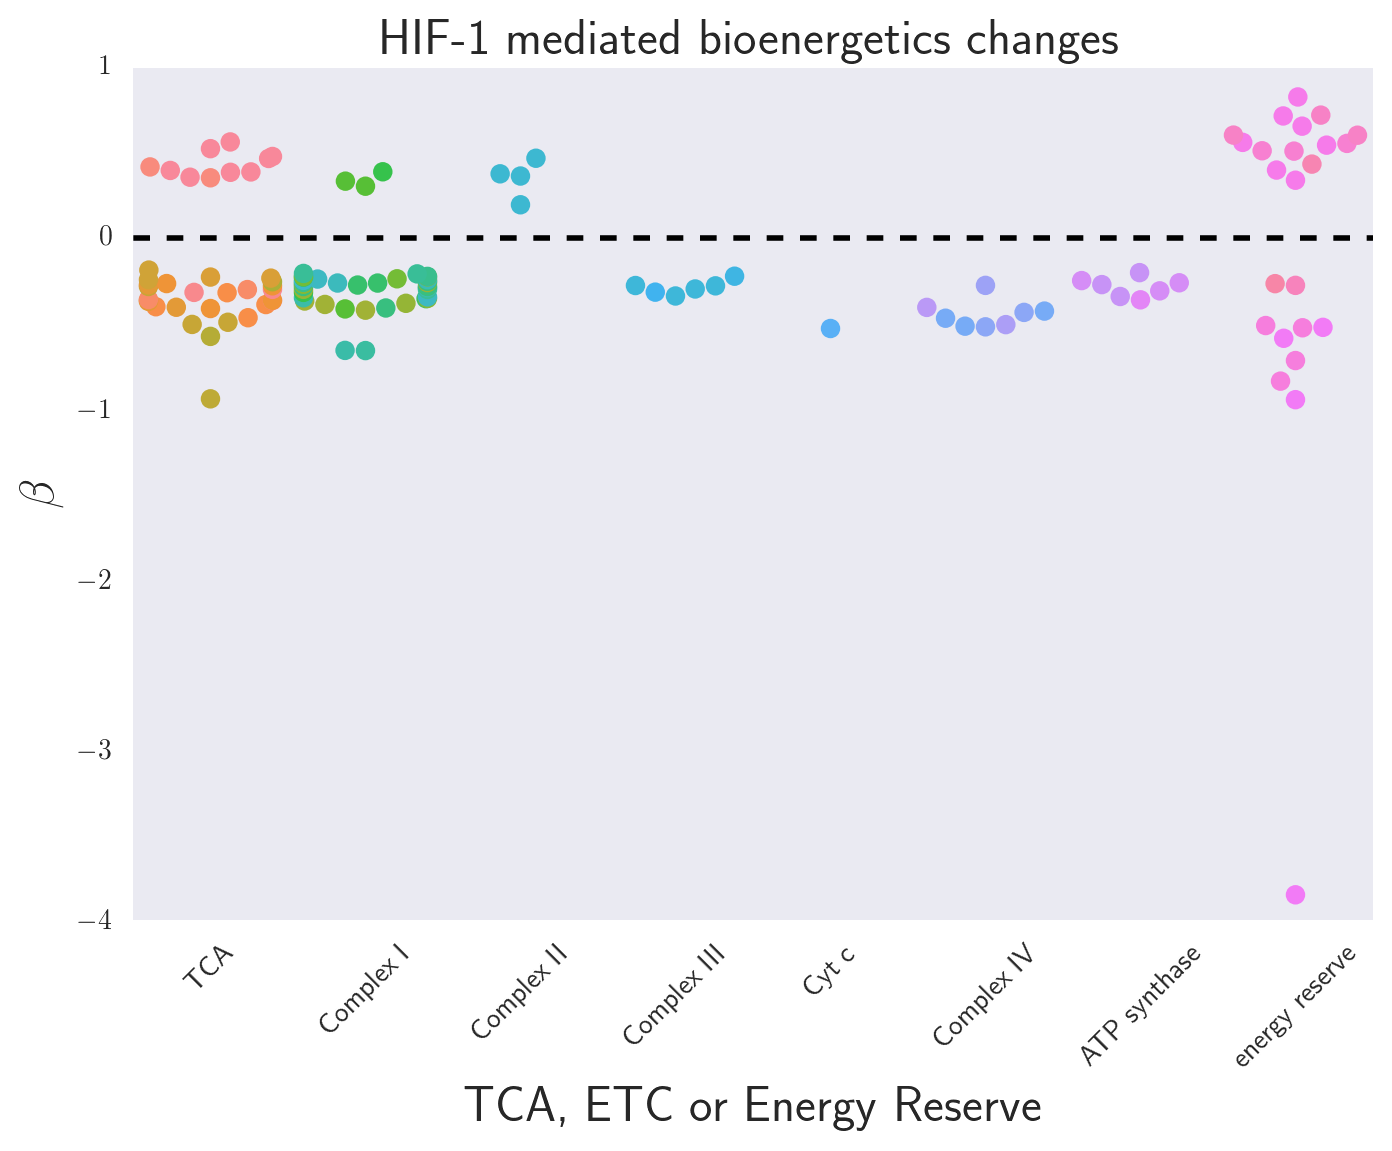

In [404]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=resp, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
plt.title('HIF-1 mediated bioenergetics changes')
plt.ylabel(r'\beta')
plt.xlabel('TCA, ETC or Energy Reserve')
ax.hlines(0, xmin=-2, xmax=10, lw=2, linestyle='--')
plt.ylim(-4, 1)
plt.savefig('../output/mito_function.pdf')

In [243]:
resp[(resp.b > 0) & (resp.complex == 'TCA')].sort_values(['genotype', 'ext_gene'])

,index,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,genotype,abs_b,complex,sort_order
16269,425,426,H14A12.2b.1,2.640269e-07,1.156917e-05,0.480973,0.093439,7.993921,0.053475,0.005212,0.005390,0.007884,0.007884,WBGene00001503,fum-1,a,0.480973,TCA,0
16268,540,541,H14A12.2a,2.440964e-06,8.430575e-05,0.526747,0.111765,6.671935,0.149591,0.007041,0.011696,0.008097,0.011696,WBGene00001503,fum-1,a,0.526747,TCA,0
13464,364,365,F46E10.10a,4.601315e-08,2.355717e-06,0.419685,0.076780,7.835079,0.233524,0.001178,0.003208,0.007665,0.007665,WBGene00018491,mdh-1,a,0.419685,TCA,0
16269,691,692,H14A12.2b.1,2.948353e-05,7.960980e-04,0.390333,0.093439,7.993921,0.053475,0.005212,0.005390,0.007884,0.007884,WBGene00001503,fum-1,b,0.390333,TCA,0
16268,986,987,H14A12.2a,3.566627e-04,6.752019e-03,0.399026,0.111765,6.671935,0.149591,0.007041,0.011696,0.008097,0.011696,WBGene00001503,fum-1,b,0.399026,TCA,0
13464,551,552,F46E10.10a,3.546471e-06,1.200467e-04,0.355978,0.076780,7.835079,0.233524,0.001178,0.003208,0.007665,0.007665,WBGene00018491,mdh-1,b,0.355978,TCA,0
16269,77,78,H14A12.2b.1,1.361628e-09,3.263783e-07,0.566234,0.093439,7.993921,0.053475,0.005212,0.005390,0.007884,0.007884,WBGene00001503,fum-1,d,0.566234,TCA,0
16268,413,414,H14A12.2a,5.147830e-04,2.313662e-02,0.388152,0.111765,6.671935,0.149591,0.007041,0.011696,0.008097,0.011696,WBGene00001503,fum-1,d,0.388152,TCA,0
16268,685,686,H14A12.2a,2.685987e-05,7.305337e-04,0.469252,0.111765,6.671935,0.149591,0.007041,0.011696,0.008097,0.011696,WBGene00001503,fum-1,e,0.469252,TCA,0
16269,909,910,H14A12.2b.1,1.199139e-04,2.462188e-03,0.359394,0.093439,7.993921,0.053475,0.005212,0.005390,0.007884,0.007884,WBGene00001503,fum-1,e,0.359394,TCA,0


In [245]:
resp[(resp.b < 0) & (resp.complex == 'energy reserve')].sort_values(['genotype', 'ext_gene'])

,index,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,genotype,abs_b,complex,sort_order
7509,940,941,D2096.3.1,1.370500e-04,2.721338e-03,-0.521227,0.136682,6.267470,0.197207,0.017540,0.010483,0.009290,0.010483,WBGene00017071,aagr-1,a,0.521227,energy reserve,10
19274,40,41,R05F9.12,1.682448e-29,7.667450e-27,-0.836623,0.074181,7.374064,0.129659,0.000841,0.004924,0.007414,0.007414,WBGene00019895,aagr-2,a,0.836623,energy reserve,10
7510,1826,1827,D2096.3.2,7.770040e-03,7.947337e-02,-3.849393,1.446106,3.722375,3.512712,3.043752,-0.718662,0.093082,0.093082,WBGene00017071,aagr-1,b,3.849393,energy reserve,10
7509,662,663,D2096.3.1,1.849857e-05,5.213359e-04,-0.585311,0.136682,6.267470,0.197207,0.017540,0.010483,0.009290,0.010483,WBGene00017071,aagr-1,b,0.585311,energy reserve,10
19274,60,61,R05F9.12,4.860498e-22,1.488826e-19,-0.715931,0.074181,7.374064,0.129659,0.000841,0.004924,0.007414,0.007414,WBGene00019895,aagr-2,b,0.715931,energy reserve,10
7509,45,46,D2096.3.1,4.618722e-12,1.876105e-09,-0.945405,0.136682,6.267470,0.197207,0.017540,0.010483,0.009290,0.010483,WBGene00017071,aagr-1,d,0.945405,energy reserve,10
19274,48,49,R05F9.12,5.844485e-12,2.228657e-09,-0.510616,0.074181,7.374064,0.129659,0.000841,0.004924,0.007414,0.007414,WBGene00019895,aagr-2,d,0.510616,energy reserve,10
19282,1052,1053,R05F9.6,3.176299e-04,5.636197e-03,-0.264938,0.073584,7.689038,0.069285,0.000597,0.006588,0.007525,0.007525,WBGene00019890,R05F9.6,e,0.264938,energy reserve,10
19274,100,101,R05F9.12,1.671958e-12,3.093122e-10,-0.523674,0.074181,7.374064,0.129659,0.000841,0.004924,0.007414,0.007414,WBGene00019895,aagr-2,e,0.523674,energy reserve,10
27682,960,961,Y46G5A.31,1.830556e-04,3.555883e-03,-0.274936,0.073486,7.647543,0.048365,0.000605,0.007459,0.007495,0.007495,WBGene00001793,gsy-1,e,0.274936,energy reserve,10


In [230]:
prot = tidy_data[tidy_data.ens_gene.isin(central_dogma.ens_gene) & (tidy_data.qval < q) & (tidy_data.genotype != 'g')].copy()
prot['complex'] = prot.ens_gene.map(lambda x: central_dogma[central_dogma.ens_gene == x].complex.values[0])
# prot['sort_order'] = resp.ens_gene.map(lambda x: respiratory_complexes[respiratory_complexes.ens_gene == x].sort_order.values[0])
# prot.sort_values('sort_order', inplace=True)

# Effects of HIF-1 on the Proteasome and Mediator

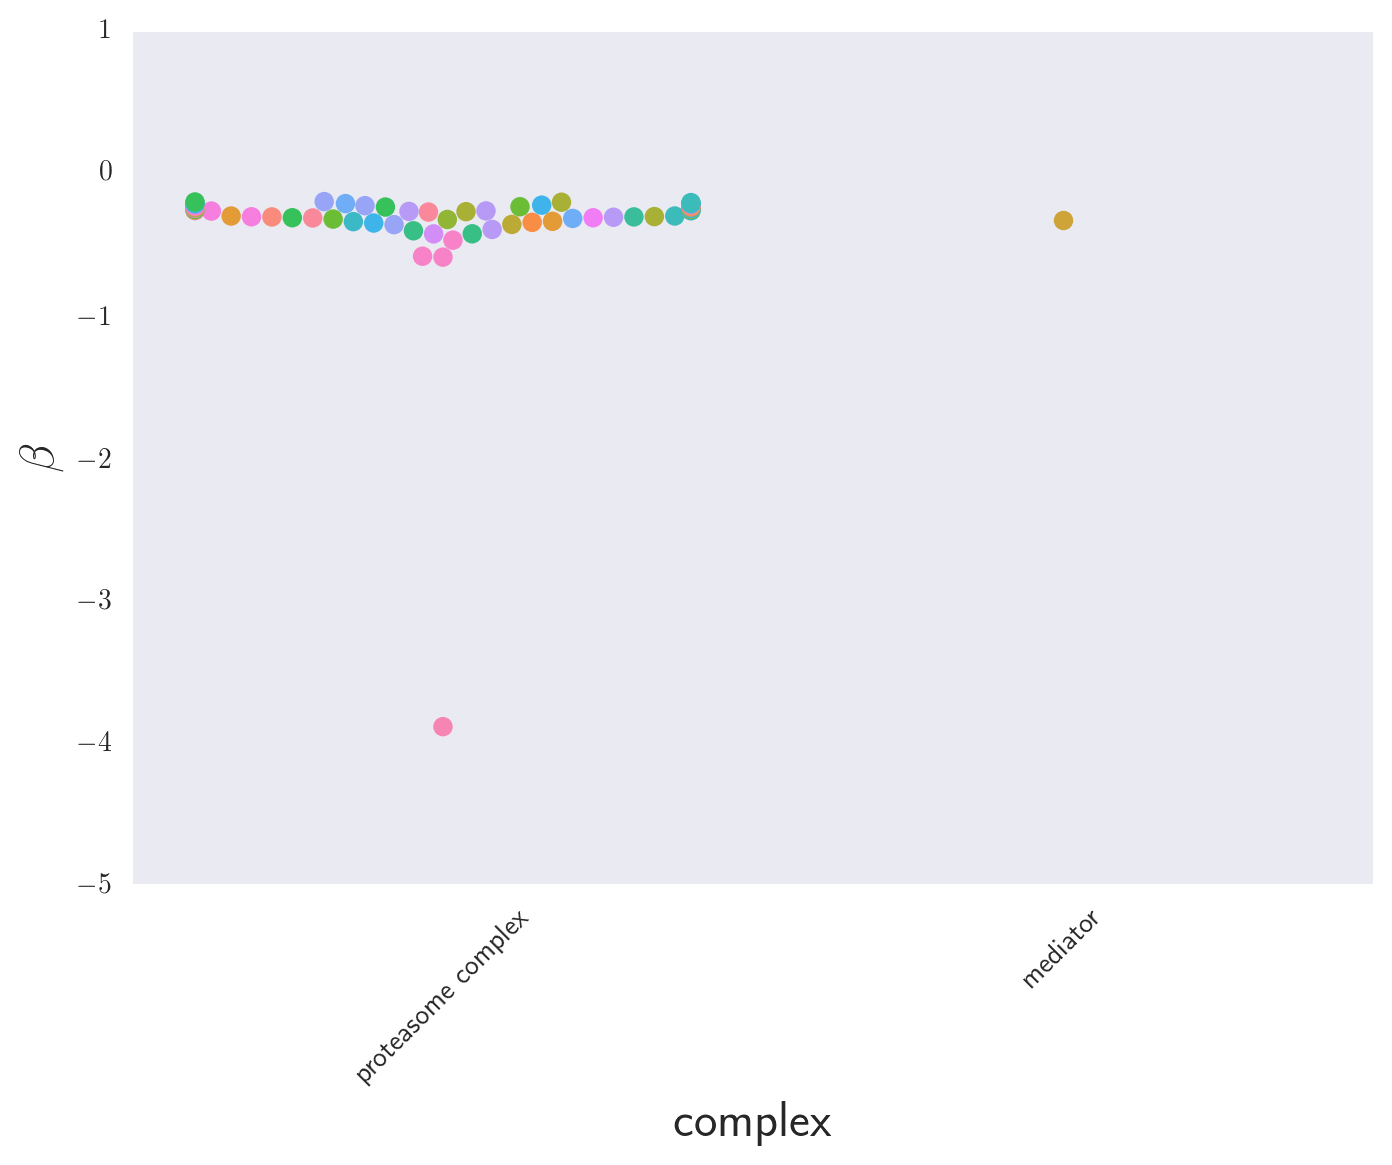

In [231]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=prot, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
# plt.title('HIF-1 mediated changes in ETC expression')
plt.ylabel(r'\beta')
# plt.xlabel('Electron Transport Chain Complexes')

## Effect of HIF-1 on proteins involved in 'protein catabolic process'
This GO term includes proteins that are involved in protein degradation, including the proteasome, a variety of ubiquitin-related enzymes and proteases

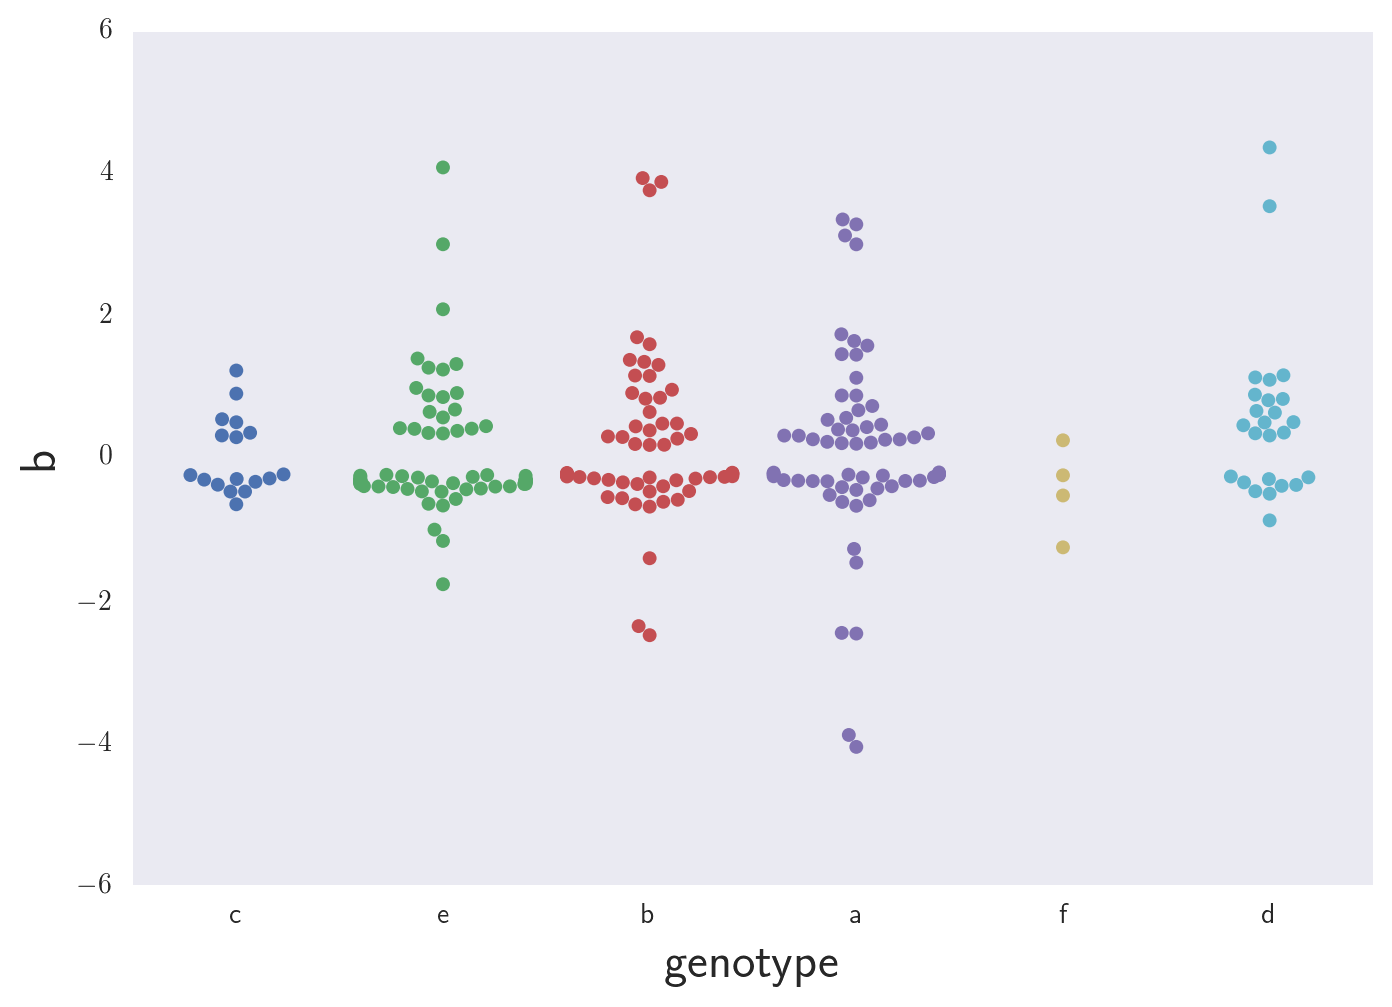

In [310]:
negregproteolysis = plot_by_term('protein catabolic process GO:0030163', melted_go)

In [330]:
tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) 
          & (tidy_data.qval < q) 
          & (tidy_data.b > 0) 
          & (tidy_data.genotype != 'g') 
          & (tidy_data.genotype == 'c')
         ].sort_values(['genotype','ext_gene'])[['qval', 'b', 'se_b',
                                                 'ens_gene', 'ext_gene']]

,qval,b,se_b,ens_gene,ext_gene
3328,0.094669,0.553463,0.185118,WBGene00015926,C17H11.6
4836,0.000388,0.362844,0.074839,WBGene00016391,C34B2.6
8943,0.000983,0.510547,0.110303,WBGene00008741,F13D12.6
27110,0.096094,0.324955,0.108978,WBGene00012747,Y40H7A.10
11351,0.089886,0.299994,0.099459,WBGene00000088,aex-5
21969,0.011718,0.913588,0.238207,WBGene00000783,cpr-3
26444,0.002856,1.238792,0.287991,WBGene00021369,siah-1


In [325]:
tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) 
          & (tidy_data.qval < q) 
          & (tidy_data.b < 0) 
          & (tidy_data.genotype != 'g') 
          & (tidy_data.genotype == 'a') 
          & (tidy_data.genotype != 'f')
          & (~tidy_data.ens_gene.isin(central_dogma[central_dogma.complex.str.contains('proteasome')].ens_gene))
         ].sort_values(['genotype', 'ext_gene'])[['qval', 'b', 'se_b', 'ens_gene', 'ext_gene']]

,qval,b,se_b,ens_gene,ext_gene
1450,6.514639e-05,-0.665202,0.139316,WBGene00015434,C04E12.4
3038,9.257257e-02,-0.420880,0.168250,WBGene00015818,C16A11.5
11321,1.339379e-05,-0.513237,0.100342,WBGene00017969,F32A5.3
11781,2.602088e-13,-2.454326,0.308934,WBGene00018052,F35F10.1
22760,5.078906e-02,-1.465387,0.527074,WBGene00020611,T20D4.5
25754,7.576523e-02,-0.320157,0.123271,WBGene00022471,Y119C1B.5
30916,7.748570e-02,-0.442007,0.170890,WBGene00022358,Y92H12A.2
17988,6.166688e-10,-1.272302,0.185565,WBGene00019619,asp-14
15953,7.343432e-29,-2.463723,0.210817,WBGene00019105,asp-8
20783,1.148717e-03,-0.402882,0.099137,WBGene00000776,cpl-1


In [324]:
tidy_data[(tidy_data.ens_gene.isin(negregproteolysis)) 
          & (tidy_data.qval < q) 
          & (tidy_data.genotype != 'g')
          & (tidy_data.ext_gene == 'unc-87')].sort_values(['genotype', 'ext_gene'])

,index,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,genotype,abs_b
8205,855,856,F08B6.4b,0.000080,0.001755,-0.317235,0.08045,8.125305,0.115285,0.000432,0.009277,0.008122,0.009277,WBGene00006819,unc-87,a,0.317235
8205,1794,1795,F08B6.4b,0.007103,0.073912,-0.216571,0.08045,8.125305,0.115285,0.000432,0.009277,0.008122,0.009277,WBGene00006819,unc-87,b,0.216571
8205,1065,1066,F08B6.4b,0.000345,0.006052,-0.287910,0.08045,8.125305,0.115285,0.000432,0.009277,0.008122,0.009277,WBGene00006819,unc-87,e,0.287910


# Predicting the Egl phenotype

In [372]:
sig = tidy_data[(tidy_data.qval < q) & (tidy_data.genotype != 'g')].ens_gene

In [373]:
eglpresent = melted_phenotype[(melted_phenotype.term.str.contains('egg laying')) & (melted_phenotype.wbid.isin(downreg))].wbid

In [374]:
egl_df = tidy_data[(tidy_data.ens_gene.isin(eglpresent)) & (tidy_data.qval < q) & (tidy_data.genotype != 'g')].sort_values(['genotype', 'ext_gene'])

In [378]:
for genotype in egl_df.genotype.unique():
    print(genotype, len(egl_df[egl_df.genotype == genotype]))

a 12
b 7
c 7
d 4
e 18
f 5


In [388]:
vuldf = tidy_data[tidy_data.ens_gene.isin(melted_tissue[(melted_tissue.wbid.isin(sig)) & (melted_tissue.term.str.contains('vul'))].wbid)
          & (tidy_data.qval < q) & (tidy_data.genotype != 'g')][['ens_gene', 'ext_gene', 'qval', 'b', 'se_b', 'genotype']]

for genotype in vuldf.genotype.unique():
    print(genotype, len(vuldf[vuldf.genotype == genotype]))

c 1
e 14
b 10
a 14
f 3
d 2


In [468]:
# melted_tissue[(melted_tissue.wbid.isin(downreg)) & (melted_tissue.term.str.contains('HSN'))]
hsndf = tidy_data[tidy_data.ens_gene.isin(melted_tissue[(melted_tissue.wbid.isin(sig)) & (melted_tissue.term.str.contains('HSN'))].wbid)
          & (tidy_data.qval < q) & (tidy_data.genotype != 'g')][['ens_gene', 'ext_gene', 'qval', 'b', 'se_b', 'genotype']]

for genotype in hsndf.genotype.unique():
    l = len(tidy_data[(tidy_data.genotype == genotype) & (tidy_data.qval < q)])
    f = len(hsndf[hsndf.genotype == genotype])
    print(genotype, l, f, '{0:.2f}%'.format(100*f/l))

c 504 2 0.40%
e 1924 10 0.52%
b 1591 9 0.57%
a 2129 11 0.52%
f 368 1 0.27%
d 630 4 0.63%
